In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
from sksurv.nonparametric import kaplan_meier_estimator
from survive import KaplanMeier
from lifelines.utils import median_survival_times
from dtreeviz.trees import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import KFold
import joblib
from sklearn import tree

### Modelling part

#### Feature engineering

In [2]:
def CI(df):
    total_df = pd.DataFrame()
    for j in df['Primary tumor Site'].unique():
        for i in df[df['Primary tumor Site'] == j]['gpa_range'].unique():
            df_temp = df[(df['gpa_range'] == i) &(df['Primary tumor Site'] == j)]
            kmf = KaplanMeierFitter()
            T = df_temp['months']
            E = df_temp['Died'].astype(bool)
            kmf.fit(T,E)
            median_ci = median_survival_times(kmf.confidence_interval_)
            median_ci['median'] = median_survival_times(kmf)
            median_ci['gpa_range'] = i
            median_ci['Primary tumor Site'] = j
            total_df = pd.concat([total_df,median_ci],axis = 0)
    total_df.rename(columns = {'KM_estimate_lower_0.95':'median_lower_lim','KM_estimate_upper_0.95':'median_upper_lim'},
                        inplace = True)        
    total_df = total_df[['Primary tumor Site','gpa_range','median','median_lower_lim','median_upper_lim']]
    total_df.sort_values(by = ['Primary tumor Site','gpa_range'], inplace = True)
    return total_df

In [3]:
def survival_curve_kmf(data,cluster_list,site_name = None ,classes = "gpa_range", survival_col = "Died",time_col = "months"):
    ax = plt.subplot(111)
    kmf = KaplanMeierFitter()
    ci_lst = [] #(site_name, gpa_range, median, lower_ci, higher_ci)
    for c in cluster_list:
        mask = data[classes] == c
        if len(data[survival_col][mask]) ==0:
            continue
        kmf.fit(data[time_col][mask],event_observed=data[survival_col][mask],label = f"GPA_range = {c}")
        kmf.plot_survival_function(ax=ax)
    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.title('Survival Curve for %s' % site_name)
    plt.show()

In [4]:
brain_mets = pd.read_excel('./data/BrainMets_List_July2020_LF_OS.xlsx')
brain_mets['Patients'] = brain_mets['PiCare MetID'].str.slice(15,20)

In [5]:
#### brain_mets is the original raw data 

In [6]:
def label_encoding_with_NAs(train, col):
    c = train[col].astype('category')
    d = dict(enumerate(c.cat.categories))
    new_d = {}
    for i in d:
        new_d[i+1] = d[i]
    train[col] = train[col].astype('category').cat.as_ordered()
    encoder = train[col].cat.categories
    # leaving 0 for NAs
    train[col] = train[col].cat.codes + 1
    return new_d    
    #val[col] = pd.Categorical(val[col], categories=encoder, ordered=True)
    #val[col] = val[col].cat.codes + 1


In [7]:
def reverse_label_encoding_with_NAs(train, col):
    c = train[col].astype('category')
    d = dict(enumerate(c.cat.categories))
    new_d = {}
    for i in d:
        new_d[i+1] = d[i]
    # leaving 0 for NAs
    print(new_d)
    

#### Selecting 1st row

In [8]:
brain_mets['row_num'] = brain_mets.sort_values(['Patients','Date GK'], \
             ascending=[True,True])\
             .groupby(['Patients'])\
             .cumcount() + 1
modelling_data = brain_mets[brain_mets['row_num'] == 1]

In [9]:
modelling_data.drop(['PiCare MetID', 'Failure-binary', 
                      'Failure-eventFreeTime', 'row_num',
                      'Primary tumor Histology', 'Date GK', 'Patients'
                     ,'Lateral dimension', 'AP dimension', 'Vertical dimension','GPA',
                      'RPA','ECOG','Prescribed IDL', 'Target vol in IDL', 'Target vol in IDL', 'IDL volume',
                     'Vol in 12 Gy line', 'Vol in 10 Gy line', 'Conformity index',
                     'Gradient index', 'Heterogeneity index', 'Salvage_RS', 
                      'Salv_surg', 'Headaches', 'Seizures', 'Prescription Dose', 
                      'Max Dose', 'Target vol in IDL', 'Distance from Ventricle',
                     'BRAF_status', 'CKIT_status', 'NRAS_status', 'EFGR_status',
                      'ALK_status', 'HER2-amplified status', 'Distance_from_ventricle',
                     'Target vol in IDL.1'
                     ], axis = 1, inplace = True)

/Users/anishmukherjee/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
percent_missing = modelling_data.isnull().sum()/len(modelling_data)
missing_value_df = pd.DataFrame({'column_name': modelling_data.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending = False)

,column_name,percent_missing
Race,Race,1.000000
Conc_Chemo,Conc_Chemo,0.840836
Brief location,Brief location,0.793676
Time to death,Time to death,0.224544
Neuro symptoms,Neuro symptoms,0.163987
Time between prim and met diagnosis,Time between prim and met diagnosis,0.161308
Prior_RS,Prior_RS,0.086817
Prior_EBRT,Prior_EBRT,0.053055
Maximum Tumor Diameter,Maximum Tumor Diameter,0.050375
Target volume,Target volume,0.042337


In [11]:
col_list = missing_value_df[missing_value_df['percent_missing'] < 0.40]['column_name'].values

In [12]:
col_list

array(['Follow-up time', 'Time to death', 'Age', 'Sex',
       'Primary tumor Site', 'ECM', 'Location', 'Side',
       '#Metastases at 1st GK', 'Time between prim and met diagnosis',
       'Prior SRS to same lesion', 'Prior SRS to other lesion',
       'KPS at 1st GK', 'Prior_EBRT', 'Prior_RS', 'Prior_Chemo',
       'Neuro symptoms', 'Target volume', 'Maximum Tumor Diameter'],
      dtype=object)

In [13]:
modelling_data = modelling_data[col_list]

In [14]:
### Label encoding non numeric columnms such as Sex

In [15]:
label_enc = modelling_data.iloc[:100,].applymap(np.isreal).all(0).values == False

In [16]:
label_enc_cols = list(modelling_data.iloc[:100,].applymap(np.isreal).all(0)[label_enc].index)

In [17]:
reverse_encoding = {}
for i in label_enc_cols:
    if i != 'Primary tumor Site': 
        print(i)
        reverse_encoding[i] = label_encoding_with_NAs(modelling_data, i)

Sex
ECM
Location
Side
Prior_RS
Prior_Chemo
Neuro symptoms


In [18]:
reverse_encoding

{'Sex': {1: 0, 2: 'F', 3: 'M'},
 'ECM': {1: 0, 2: 'False', 3: 'True', 4: 'Unkn'},
 'Location': {1: 'Basal Ganglia',
  2: 'Basal_Ganglia',
  3: 'Brainstem_Medulla',
  4: 'Brainstem_Midbrain',
  5: 'Brainstem_Pons',
  6: 'Cavernous Sinus',
  7: 'Cavernous_Sinus',
  8: 'Cerebellopontine Angle',
  9: 'Cerebellopontine_Angle',
  10: 'Cerebellum',
  11: 'Corpus Callosum',
  12: 'Corpus_Callosum',
  13: 'Falx',
  14: 'Frontal Lobe',
  15: 'Frontal Lobe*',
  16: 'Frontal_Lobe',
  17: 'Frontal_Motor',
  18: 'Frontoparietal',
  19: 'Frontotemporal',
  20: 'Hypothalamus',
  21: 'Insula',
  22: 'Occipital Lobe',
  23: 'Occipital Lobe(medial)',
  24: 'Occipital Lobe*',
  25: 'Occipital_Lobe',
  26: 'Orbit',
  27: 'Parafalcine Region',
  28: 'Parietal Lobe',
  29: 'Parietal Lobe*',
  30: 'Parietal_Lobe',
  31: 'Parieto-Occipital',
  32: 'Parieto-occipital',
  33: 'Pineal Region',
  34: 'Pineal_Region',
  35: 'Sella',
  36: 'Temporal Lobe',
  37: 'Temporal Lobe(inf.post)',
  38: 'Temporal Lobe*',
  3

#### Preprocessing time of death

In [19]:
modelling_data['Time to death'] = np.where((modelling_data['Time to death'].isna()) & (
                                            modelling_data['Follow-up time'] > 0),
                                          modelling_data['Follow-up time'],
                                          modelling_data['Time to death'])
modelling_data.drop('Follow-up time' , axis = 1, inplace = True)
modelling_data['Time to death'] = modelling_data['Time to death']/30.5

In [20]:
### Dropping patient having null time of death

In [21]:
modelling_data = modelling_data[(modelling_data['Time to death'].notnull() & (modelling_data['KPS at 1st GK'].notnull())
                             &(modelling_data['#Metastases at 1st GK'].notnull()))] 

In [22]:
modelling_data

,Time to death,Age,Sex,Primary tumor Site,ECM,Location,Side,#Metastases at 1st GK,Time between prim and met diagnosis,Prior SRS to same lesion,Prior SRS to other lesion,KPS at 1st GK,Prior_EBRT,Prior_RS,Prior_Chemo,Neuro symptoms,Target volume,Maximum Tumor Diameter
0,6.721311,51.369863,2,Lung,2,10,3,3.0,6.0,0,0,80.0,True,1,3,2,15.500,3.9
3,1.573770,77.591781,2,Lung,2,44,0,5.0,896.0,0,0,60.0,True,1,3,2,0.230,0.9
8,6.196721,45.400000,3,Melanoma,3,14,1,4.0,4.0,0,0,90.0,True,1,2,1,0.030,0.3
12,4.163934,51.564384,2,Melanoma,3,28,1,2.0,3265.0,0,0,70.0,False,1,3,1,1.600,1.8
14,0.622951,39.726027,3,Lung,3,10,3,6.0,178.0,0,0,90.0,True,2,3,2,2.700,2.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10304,0.524590,57.676712,2,Lung,3,0,0,24.0,210.0,0,0,80.0,False,1,1,2,NaN,NaN
10378,9.049180,62.284932,2,GYN,1,0,0,9.0,1262.0,0,0,90.0,False,1,1,1,NaN,NaN
10396,4.032787,62.120548,3,Lung,1,0,0,3.0,425.0,0,0,80.0,True,1,1,2,NaN,NaN
10425,6.065574,33.701370,2,Breast,1,39,1,1.0,NaN,0,0,90.0,NaN,0,1,0,0.608,1.2


#### filling null values by median

In [23]:
modelling_data.fillna(modelling_data.median(), inplace = True)

In [24]:
## Controlling the decsion trees hyperparameters
from random import sample
def get_random_hyper():
    min_samples_leaf = np.random.randint(low = 4, high =80, size=1)[0]
    # max_leaf_nodes = np.random.randint(low = 1, high = leaves, size=1)[0]
    max_features = sample(['auto','sqrt','log2'],1)
    return min_samples_leaf,max_features[0]

In [25]:
def pick_best_model(modelling_data, indication, iterations, max_leaf_nodes):
    y = modelling_data[modelling_data['Primary tumor Site'] == indication]['Time to death']
    x = modelling_data[modelling_data['Primary tumor Site'] == indication].drop(['Time to death','Primary tumor Site'],axis =1)
    x.reset_index(inplace = True)
    x.drop('index', inplace = True, axis = 1)
    y.reset_index(inplace = True, drop = True)
    max_rsquared = -100
    y_test_total = []
    ## iterating over the decision tree hyperparameters and picking the best
    kf = KFold(n_splits = 5)
    kf.get_n_splits(x)
    y_pred = []
    for i in range(0,iterations):
        min_samples_leaf,max_features = get_random_hyper()
        dt = DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes,
                                       min_samples_leaf = min_samples_leaf, 
                                       max_features = max_features)
        for train_index, test_index in kf.split(x):
            x_train, x_test = x.iloc[train_index], x.iloc[test_index] 
            y_train, y_test = y[train_index], y[test_index]
            dt.fit(x_train, y_train)
            y_pred.append(dt.predict(x_test))
            y_test_total.append(y_test)
        r_squared = r2_score(np.concatenate(y_test_total), np.concatenate(y_pred))
        if r_squared > max_rsquared:
            max_rsquared = r_squared
            best_model = dt
    best_model.fit(x,y)        
    return max_rsquared, best_model        

In [26]:
def survival_curve_and_ci(best_model,modelling_data, indication, tolerance = 0.1):
    y = modelling_data[modelling_data['Primary tumor Site'] == indication]['Time to death']
    x = modelling_data[modelling_data['Primary tumor Site'] == indication].drop(['Time to death','Primary tumor Site'],axis =1)
    x.reset_index(inplace = True)
    x.drop('index', inplace = True, axis = 1)
    y.reset_index(inplace = True, drop = True)
    prediction = best_model.predict(x)
    prediction = pd.Series(prediction)
    df = pd.concat([y,prediction],axis = 1)
    df.rename(columns = {0: 'prediction'}, inplace = True)
    a = list(df['prediction'].unique())
    a.sort()
    pred_to_gpa = {a[0]:0}
    class_num = 0
    epsilon = 0
    for i in range(1,len(a)):
        epsilon = a[i] - a[i-1]
        if epsilon > tolerance:
            class_num = class_num + 1 
        pred_to_gpa[a[i]] = class_num    
    df['New_GPA'] = df['prediction'].map(lambda x: pred_to_gpa[x])
    df['Died'] = True
    df.drop('prediction', axis  = 1, inplace = True)
    gpa_range = list(df['New_GPA'].unique())
    gpa_range.sort()
    survival_curve_kmf(df, gpa_range, site_name = indication, 
                   classes = "New_GPA", survival_col = "Died",time_col = "Time to death")
    df['Primary tumor Site'] = indication
    df.rename(columns  = {'Time to death': 'months', 'New_GPA': 'gpa_range'}, inplace = True)
    df_ci = CI(df)
    return df_ci
    

In [27]:
def tree_plot(best_model, modelling_data, indication):
    y = modelling_data[modelling_data['Primary tumor Site'] == indication]['Time to death']
    x = modelling_data[modelling_data['Primary tumor Site'] == indication].drop(['Time to death','Primary tumor Site'],axis =1)
    x.reset_index(inplace = True)
    x.drop('index', inplace = True, axis = 1)
    y.reset_index(inplace = True, drop = True)
    viz = dtreeviz(best_model, x, y,
                target_name="survival_length",
                feature_names=x.columns)
    return viz

In [28]:
def tree_plot_2(best_model, modelling_data, indication, h = 8,w = 8):
    fig = plt.figure(figsize=(h,w))
    y = modelling_data[modelling_data['Primary tumor Site'] == indication]['Time to death']
    x = modelling_data[modelling_data['Primary tumor Site'] == indication].drop(['Time to death','Primary tumor Site'],axis =1)
    x.reset_index(inplace = True)
    x.drop('index', inplace = True, axis = 1)
    y.reset_index(inplace = True, drop = True)
    viz = tree.plot_tree(best_model, 
                class_names = y,
                feature_names=x.columns)
    plt.show()
    return viz

### MELANOMA

### 2 Classes

#### max leaf nodes 2

In [29]:
best_model_melanoma = []

In [30]:
### Use existing models
best_model_melanoma.append(joblib.load('melanoma_2_leaf_node_2_gpa'))
best_model_melanoma.append(joblib.load('melanoma_4_leaf_node_2_gpa'))
best_model_melanoma.append(joblib.load('melanoma_3_leaf_node_3_gpa'))
best_model_melanoma.append(joblib.load('melanoma_5_leaf_node_3_gpa'))
best_model_melanoma.append(joblib.load('melanoma_6_leaf_node_3_gpa'))
best_model_melanoma.append(joblib.load('melanoma_4_leaf_node_4_gpa'))

In [1033]:
rsquared, best_model = pick_best_model(modelling_data, 'Melanoma', iterations = 25, max_leaf_nodes = 2 )

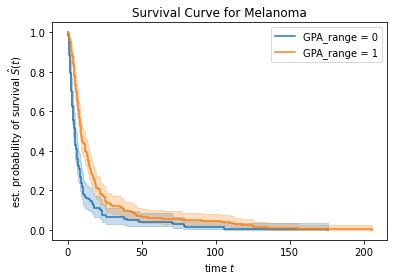

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,4.622951,3.606557,5.409836
0.5,Melanoma,1,8.885246,7.639344,11.475410


In [34]:
survival_curve_and_ci(best_model_melanoma[0],modelling_data, indication = 'Melanoma', tolerance = 0)

In [1035]:
best_model_melanoma.append(best_model)

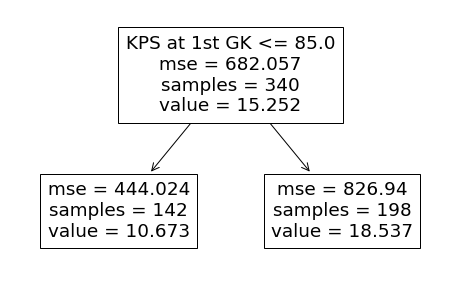

In [33]:
tree_plot_2(best_model_melanoma[0],modelling_data, 'Melanoma', w = 5)
plt.show()

#### max 4 Leaf nodes

In [ ]:
rsquared, best_model = pick_best_model(modelling_data, 'Melanoma', iterations = 25, max_leaf_nodes = 4 )

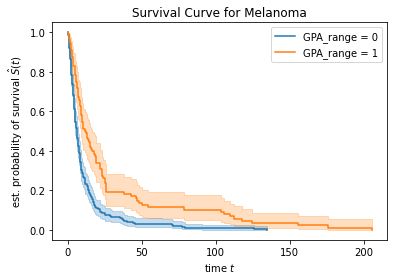

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,6.131148,4.950820,7.180328
0.5,Melanoma,1,11.475410,8.885246,16.131148


In [36]:
survival_curve_and_ci(best_model_melanoma[1],modelling_data, indication = 'Melanoma', tolerance = 1)

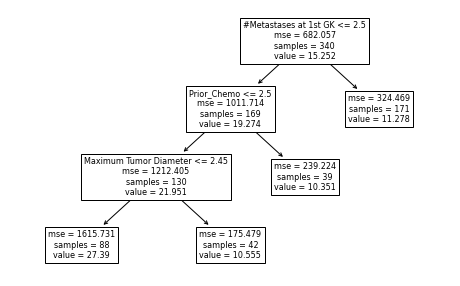

In [36]:
tree_plot_2(best_model_melanoma[1],modelling_data, 'Melanoma', w = 5)
plt.show()

### 3 Classes

#### Max Leaf nodes 3

In [1053]:
rsquared, best_model = pick_best_model(modelling_data, 'Melanoma', iterations = 25, max_leaf_nodes = 3 )

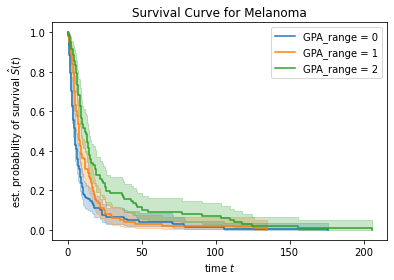

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,4.622951,3.606557,5.409836
0.5,Melanoma,1,7.409836,6.000000,8.754098
0.5,Melanoma,2,11.475410,8.885246,14.590164


In [38]:
survival_curve_and_ci(best_model_melanoma[2],modelling_data, indication = 'Melanoma', tolerance = 1)

In [1055]:
best_model_melanoma.append(best_model)

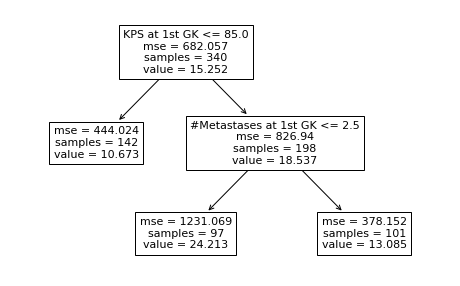

In [38]:
tree_plot_2(best_model_melanoma[2],modelling_data, 'Melanoma' , w = 5)
plt.show()

#### Max Leaf nodes 5

In [ ]:
rsquared, best_model = pick_best_model(modelling_data, 'Melanoma', iterations = 55, max_leaf_nodes = 5 )

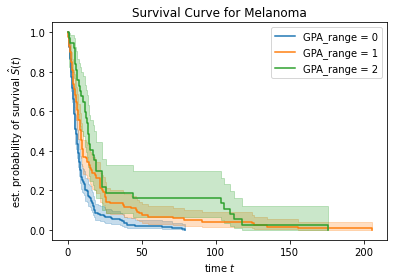

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,5.409836,4.622951,6.754098
0.5,Melanoma,1,8.819672,6.885246,9.803279
0.5,Melanoma,2,13.868852,10.622951,19.278689


In [40]:
survival_curve_and_ci(best_model_melanoma[3],modelling_data, indication = 'Melanoma', tolerance = 0.5)

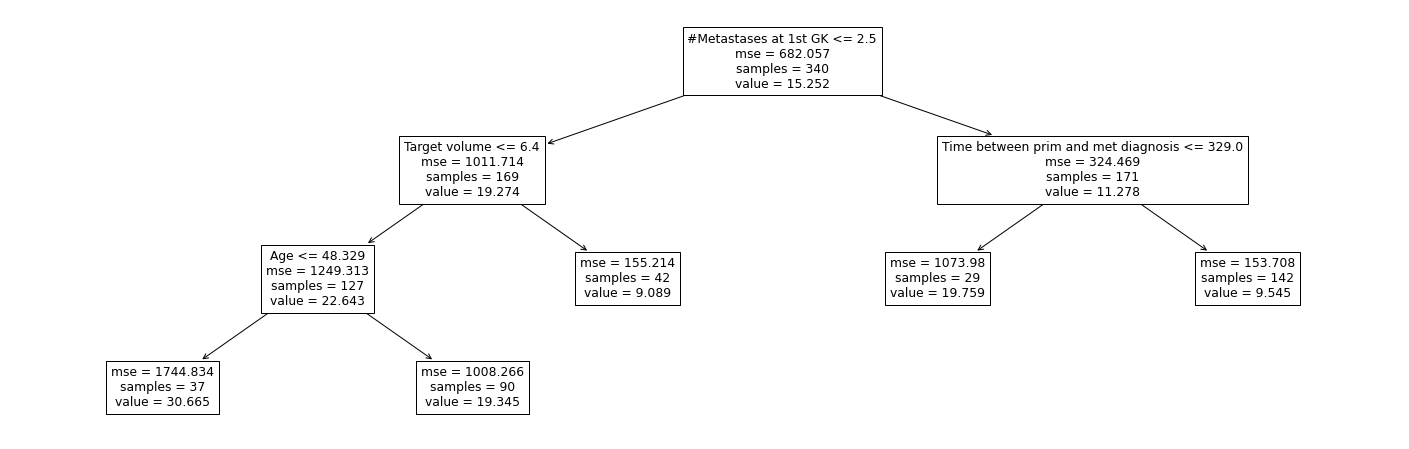

In [41]:
tree_plot_2(best_model_melanoma[3],modelling_data, 'Melanoma', h = 25)
plt.show()

In [ ]:
best_model_melanoma.append(best_model)

#### Max Leaf nodes > 6

In [ ]:
rsquared, best_model = pick_best_model(modelling_data, 'Melanoma', iterations = 25, max_leaf_nodes = 100 )

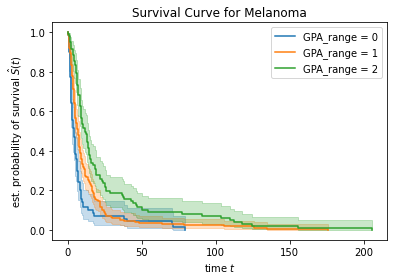

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,4.131148,2.721311,4.950820
0.5,Melanoma,1,6.754098,5.180328,7.934426
0.5,Melanoma,2,11.475410,8.885246,14.590164


In [42]:
survival_curve_and_ci(best_model_melanoma[4],modelling_data, indication = 'Melanoma', tolerance = 1)

In [ ]:
best_model_melanoma.append(best_model)

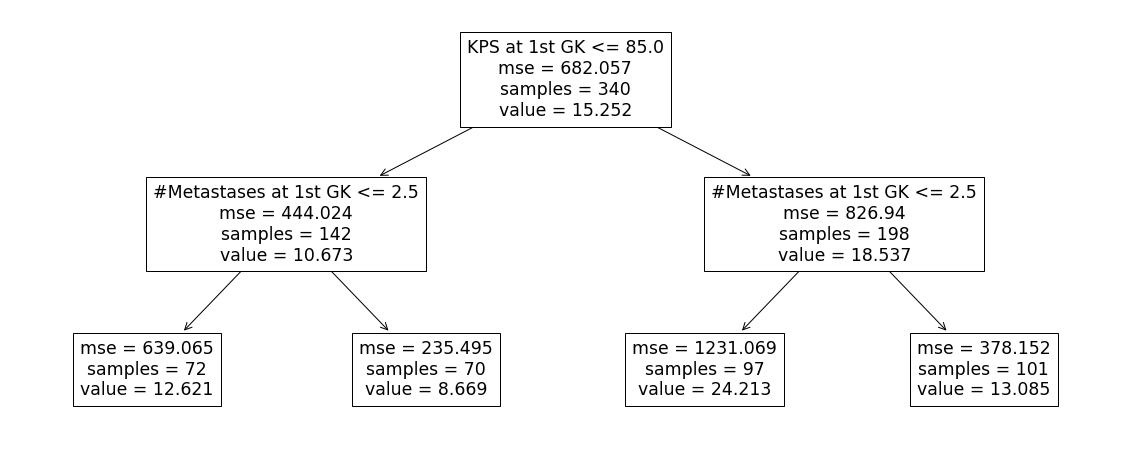

In [43]:
tree_plot_2(best_model_melanoma[4],modelling_data, 'Melanoma', h = 20)
plt.show()

### 4 Classes

In [52]:
rsquared, best_model = pick_best_model(modelling_data, 'Melanoma', iterations = 25, max_leaf_nodes = 4)


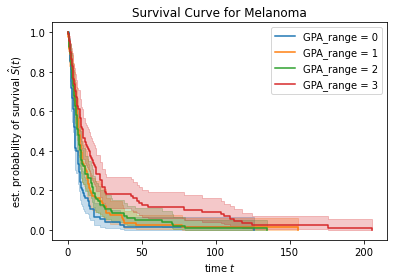

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,4.622951,3.540984,6.852459
0.5,Melanoma,1,7.606557,6.196721,9.278689
0.5,Melanoma,2,7.180328,5.573770,8.754098
0.5,Melanoma,3,10.032787,8.163934,14.590164


In [44]:
survival_curve_and_ci(best_model_melanoma[5],modelling_data, indication = 'Melanoma', tolerance = 0)

In [1109]:
best_model_melanoma.append(best_model)

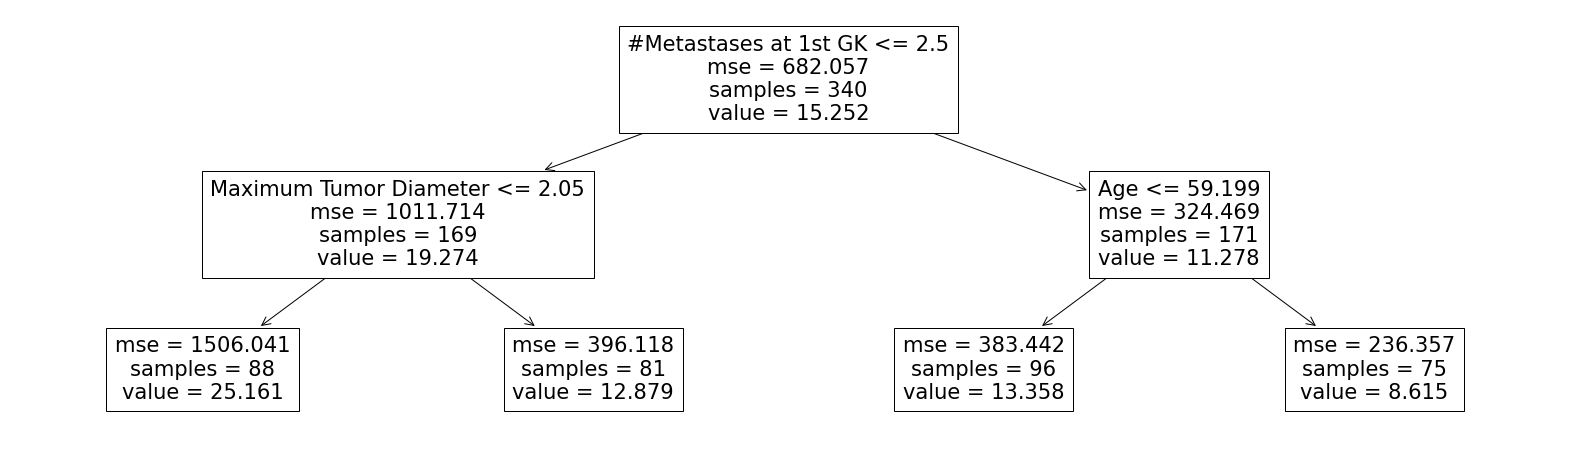

In [46]:
tree_plot_2(best_model_melanoma[5],modelling_data, 'Melanoma', h = 28)
plt.show()

In [46]:
best_model_melanoma

[DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=2,
                       min_samples_leaf=62),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=4, min_samples_leaf=4),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=3,
                       min_samples_leaf=36),
 DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=5,
                       min_samples_leaf=28),
 DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=100,
                       min_samples_leaf=64),
 DecisionTreeRegressor(max_features='auto', max_leaf_nodes=4,
                       min_samples_leaf=63)]

0.0032916804967897395

In [ ]:
joblib.dump(best_model_melanoma[0], 'melanoma_2_leaf_node_2_gpa')
joblib.dump(best_model_melanoma[1], 'melanoma_4_leaf_node_2_gpa')
joblib.dump(best_model_melanoma[2], 'melanoma_3_leaf_node_3_gpa')
joblib.dump(best_model_melanoma[3], 'melanoma_5_leaf_node_3_gpa')
joblib.dump(best_model_melanoma[4], 'melanoma_6_leaf_node_3_gpa')
joblib.dump(best_model_melanoma[5], 'melanoma_4_leaf_node_4_gpa')

In [ ]:
### Run DT taking out either diameter or target volume

### Taking out max tumor diameter

### 2 Classes

In [48]:
best_model_melanoma_w_max_dia = []
modelling_data_w_max_dia = modelling_data.drop('Maximum Tumor Diameter', axis = 1)

In [49]:
### Use existing models
best_model_melanoma_w_max_dia.append(joblib.load('melanoma_2_leaf_node_2_gpa_w_max_dia'))
best_model_melanoma_w_max_dia.append(joblib.load('melanoma_4_leaf_node_2_gpa_w_max_dia'))
best_model_melanoma_w_max_dia.append(joblib.load('melanoma_3_leaf_node_3_gpa_w_max_dia'))
best_model_melanoma_w_max_dia.append(joblib.load('melanoma_5_leaf_node_3_gpa_w_max_dia'))
best_model_melanoma_w_max_dia.append(joblib.load('melanoma_6_leaf_node_3_gpa_w_max_dia'))
best_model_melanoma_w_max_dia.append(joblib.load('melanoma_4_leaf_node_4_gpa_w_max_dia'))

In [141]:
rsquared, best_model = pick_best_model(modelling_data_w_max_dia, 'Melanoma', iterations = 55, max_leaf_nodes = 2 )

In [144]:
best_model_melanoma_w_max_dia.append(best_model)

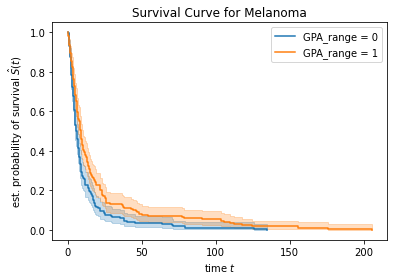

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,6.000000,4.918033,7.180328
0.5,Melanoma,1,8.819672,7.114754,10.032787


In [50]:
survival_curve_and_ci(best_model_melanoma_w_max_dia[0],modelling_data_w_max_dia, 
                      indication = 'Melanoma', tolerance = 0)

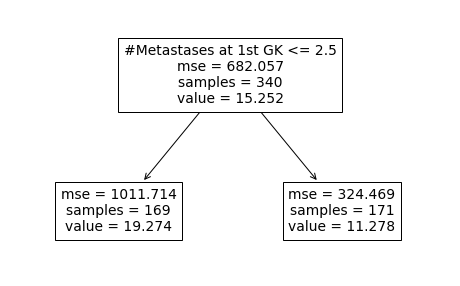

In [50]:
tree_plot_2(best_model_melanoma_w_max_dia[0],modelling_data_w_max_dia, 'Melanoma', w = 5)
plt.show()

In [147]:
best_model_melanoma_w_max_dia

[DecisionTreeRegressor(max_features='auto', max_leaf_nodes=2,
                       min_samples_leaf=76)]

#### max 4 Leaf nodes

In [148]:
rsquared, best_model = pick_best_model(modelling_data_w_max_dia, 'Melanoma', iterations = 25, max_leaf_nodes = 4)

In [150]:
best_model_melanoma_w_max_dia.append(best_model)

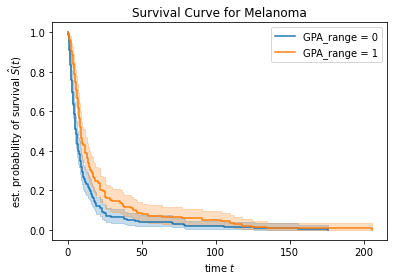

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,5.409836,4.622951,6.754098
0.5,Melanoma,1,8.852459,7.573770,11.508197


In [52]:
survival_curve_and_ci(best_model_melanoma_w_max_dia[1],modelling_data_w_max_dia, indication = 'Melanoma', tolerance = 1)

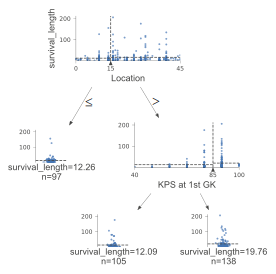

In [149]:
tree_plot(best_model_melanoma_w_max_dia[1],modelling_data_w_max_dia, 'Melanoma')

In [153]:
best_model_melanoma_w_max_dia

[DecisionTreeRegressor(max_features='auto', max_leaf_nodes=2,
                       min_samples_leaf=76),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=4,
                       min_samples_leaf=74)]

### 3 Classes

#### Max Leaf nodes 3

In [162]:
rsquared, best_model = pick_best_model(modelling_data_w_max_dia, 'Melanoma', iterations = 25, max_leaf_nodes = 3)

In [164]:
best_model_melanoma_w_max_dia.append(best_model)

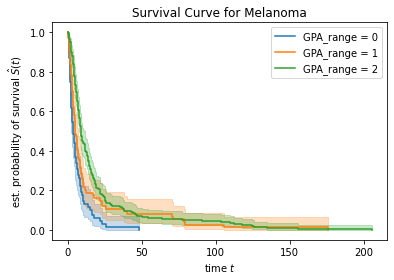

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,3.672131,2.557377,4.950820
0.5,Melanoma,1,4.754098,3.967213,7.180328
0.5,Melanoma,2,8.885246,7.639344,11.475410


In [54]:
survival_curve_and_ci(best_model_melanoma_w_max_dia[2],modelling_data_w_max_dia, indication = 'Melanoma', tolerance = 0)

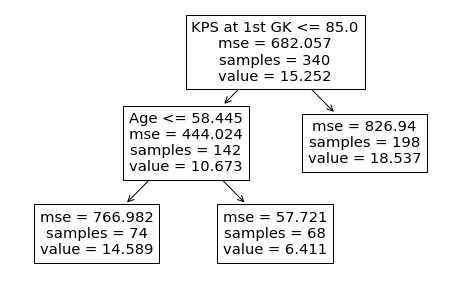

In [53]:
tree_plot_2(best_model_melanoma_w_max_dia[2],modelling_data_w_max_dia, 'Melanoma', w = 5)
plt.show()

#### Max Leaf nodes 5

In [181]:
rsquared, best_model = pick_best_model(modelling_data_w_max_dia, 'Melanoma', iterations = 55, max_leaf_nodes = 5 )

In [185]:
best_model_melanoma_w_max_dia.append(best_model)

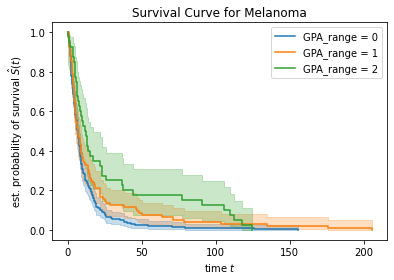

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,6.754098,5.573770,7.639344
0.5,Melanoma,1,7.114754,4.885246,9.278689
0.5,Melanoma,2,12.032787,7.049180,17.311475


In [56]:
survival_curve_and_ci(best_model_melanoma_w_max_dia[3],modelling_data_w_max_dia, indication = 'Melanoma', tolerance = 2.5)

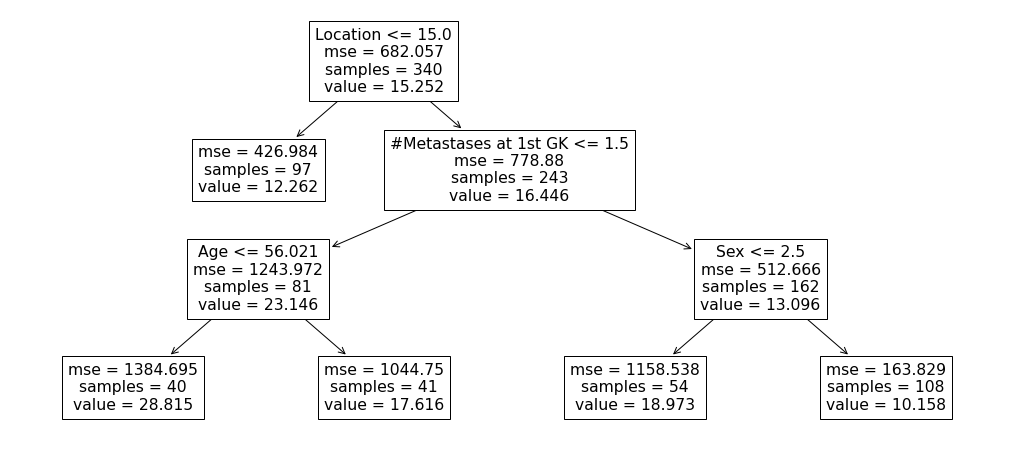

In [55]:
tree_plot_2(best_model_melanoma_w_max_dia[3],modelling_data_w_max_dia, 'Melanoma', h = 18)
plt.show()

#### Max Leaf nodes > 6

In [194]:
rsquared, best_model = pick_best_model(modelling_data_w_max_dia, 'Melanoma', iterations = 25, max_leaf_nodes = 100 )

In [195]:
best_model_melanoma_w_max_dia.append(best_model)

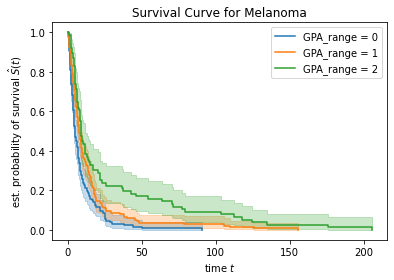

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,4.688525,3.967213,6.754098
0.5,Melanoma,1,7.934426,6.262295,9.213115
0.5,Melanoma,2,9.278689,7.114754,11.967213


In [58]:
survival_curve_and_ci(best_model_melanoma_w_max_dia[4],modelling_data_w_max_dia, 
                      indication = 'Melanoma', tolerance = 1)

In [ ]:
best_model_melanoma.append(best_model)

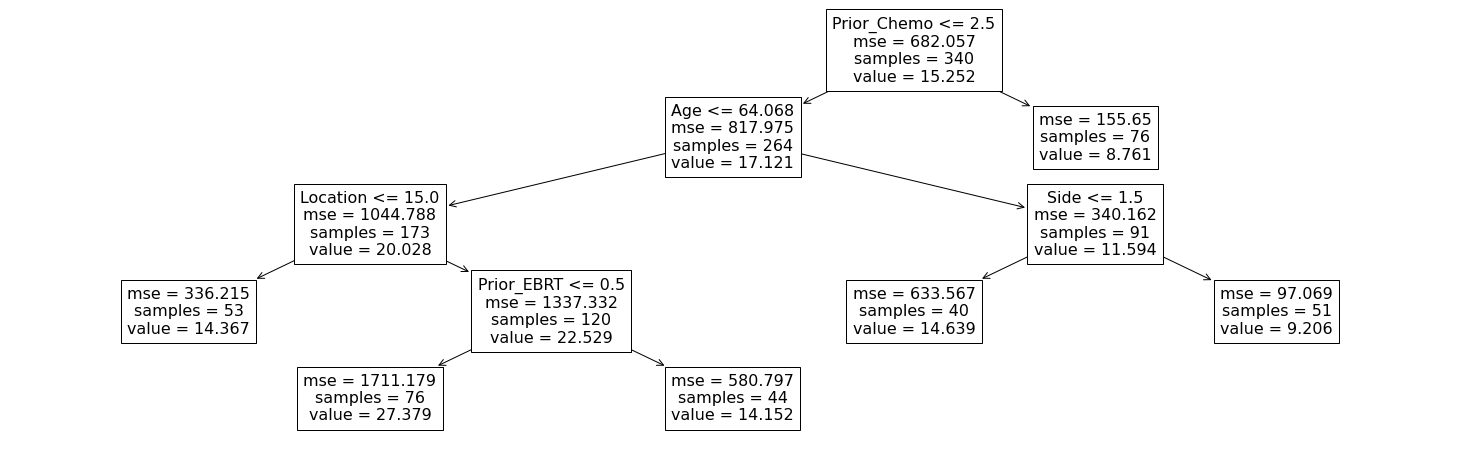

In [57]:
tree_plot_2(best_model_melanoma_w_max_dia[4],modelling_data_w_max_dia, 'Melanoma' , h = 26)
plt.show()

### 4 Classes

In [206]:
rsquared, best_model = pick_best_model(modelling_data_w_max_dia, 'Melanoma', iterations = 25, max_leaf_nodes = 4)


In [208]:
best_model_melanoma_w_max_dia.append(best_model)

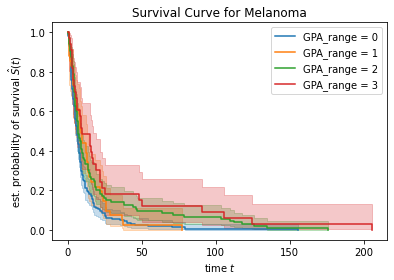

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,6.262295,4.950820,7.377049
0.5,Melanoma,1,8.852459,4.819672,13.311475
0.5,Melanoma,2,7.180328,5.672131,9.803279
0.5,Melanoma,3,9.377049,5.442623,17.311475


In [60]:
survival_curve_and_ci(best_model_melanoma_w_max_dia[5],modelling_data_w_max_dia, indication = 'Melanoma', tolerance = 0)

In [1109]:
best_model_melanoma.append(best_model)

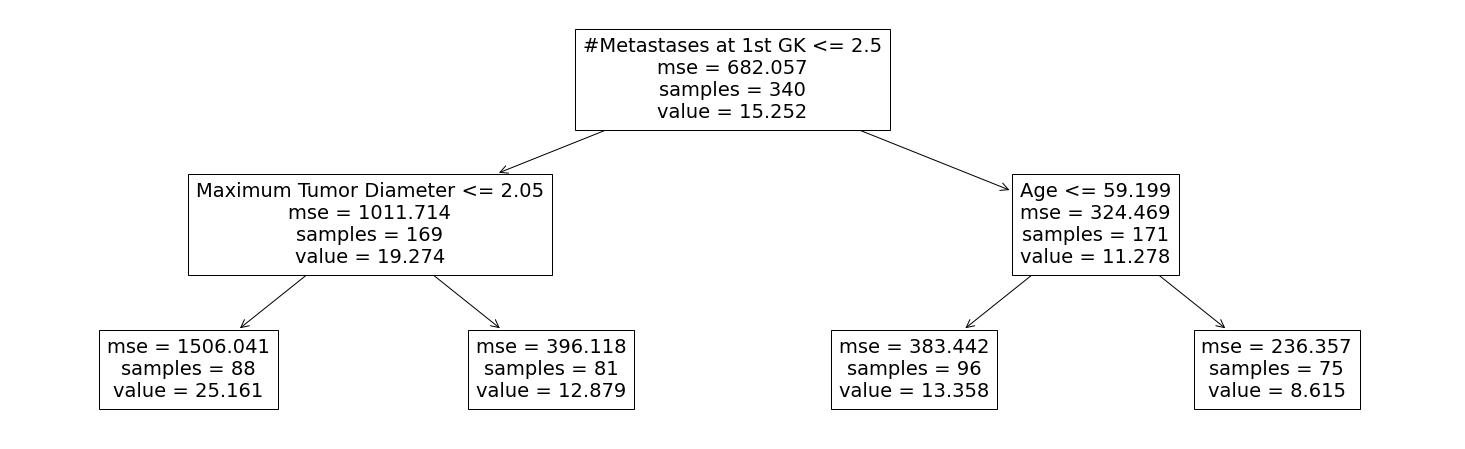

In [60]:
tree_plot_2(best_model_melanoma[5],modelling_data, 'Melanoma', h = 26)
plt.show()

In [62]:
best_model_melanoma_w_max_dia

[DecisionTreeRegressor(max_features='auto', max_leaf_nodes=2,
                       min_samples_leaf=76),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=4,
                       min_samples_leaf=74),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=3,
                       min_samples_leaf=53),
 DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=5,
                       min_samples_leaf=39),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=100,
                       min_samples_leaf=38),
 DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=4,
                       min_samples_leaf=29)]

In [212]:
joblib.dump(best_model_melanoma_w_max_dia[0], 'melanoma_2_leaf_node_2_gpa_w_max_dia')
joblib.dump(best_model_melanoma_w_max_dia[1], 'melanoma_4_leaf_node_2_gpa_w_max_dia')
joblib.dump(best_model_melanoma_w_max_dia[2], 'melanoma_3_leaf_node_3_gpa_w_max_dia')
joblib.dump(best_model_melanoma_w_max_dia[3], 'melanoma_5_leaf_node_3_gpa_w_max_dia')
joblib.dump(best_model_melanoma_w_max_dia[4], 'melanoma_6_leaf_node_3_gpa_w_max_dia')
joblib.dump(best_model_melanoma_w_max_dia[5], 'melanoma_4_leaf_node_4_gpa_w_max_dia')

['melanoma_4_leaf_node_4_gpa_w_max_dia']

### REMOVING TARGET VOLUME

### 2 Classes

In [62]:
best_model_melanoma_w_tar_vol = []
modelling_data_w_tar_vol = modelling_data.drop('Target volume', axis = 1)

In [63]:
### Use existing models
best_model_melanoma_w_tar_vol.append(joblib.load('melanoma_2_leaf_node_2_gpa_w_tar_vol'))
best_model_melanoma_w_tar_vol.append(joblib.load('melanoma_4_leaf_node_2_gpa_w_tar_vol'))
best_model_melanoma_w_tar_vol.append(joblib.load('melanoma_3_leaf_node_3_gpa_w_tar_vol'))
best_model_melanoma_w_tar_vol.append(joblib.load('melanoma_5_leaf_node_3_gpa_w_tar_vol'))
best_model_melanoma_w_tar_vol.append(joblib.load('melanoma_6_leaf_node_3_gpa_w_tar_vol'))
best_model_melanoma_w_tar_vol.append(joblib.load('melanoma_4_leaf_node_4_gpa_w_tar_vol'))

In [219]:
rsquared, best_model = pick_best_model(modelling_data_w_tar_vol, 'Melanoma', iterations = 55, max_leaf_nodes = 2 )

In [221]:
best_model_melanoma_w_tar_vol.append(best_model)

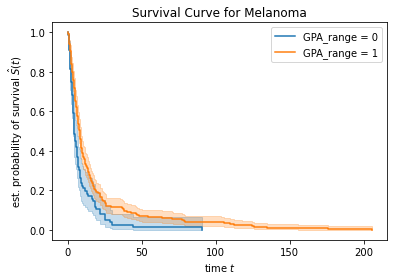

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,4.491803,3.606557,6.426230
0.5,Melanoma,1,8.065574,7.049180,9.114754


In [65]:
survival_curve_and_ci(best_model_melanoma_w_tar_vol[0],modelling_data_w_tar_vol, 
                      indication = 'Melanoma', tolerance = 0)

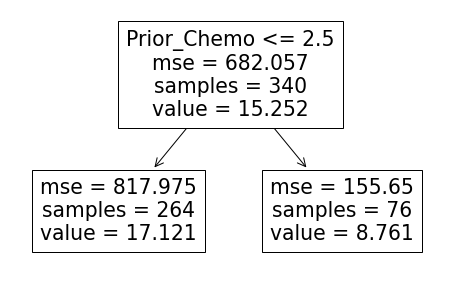

In [66]:
tree_plot_2(best_model_melanoma_w_tar_vol[0],modelling_data_w_tar_vol, 'Melanoma', w = 5)
plt.show()

In [223]:
best_model_melanoma_w_tar_vol

[DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=2,
                       min_samples_leaf=63)]

#### max 4 Leaf nodes

In [228]:
rsquared, best_model = pick_best_model(modelling_data_w_tar_vol, 'Melanoma', iterations = 25, max_leaf_nodes = 4)

In [237]:
best_model_melanoma_w_tar_vol.append(best_model)

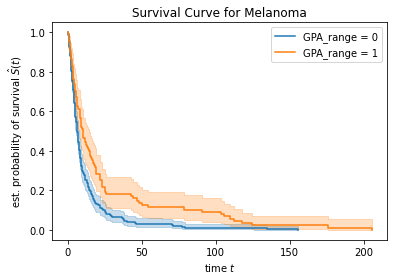

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,6.426230,5.409836,7.344262
0.5,Melanoma,1,10.032787,8.163934,14.590164


In [67]:
survival_curve_and_ci(best_model_melanoma_w_tar_vol[1],
                      modelling_data_w_tar_vol, indication = 'Melanoma', tolerance = 4.4)

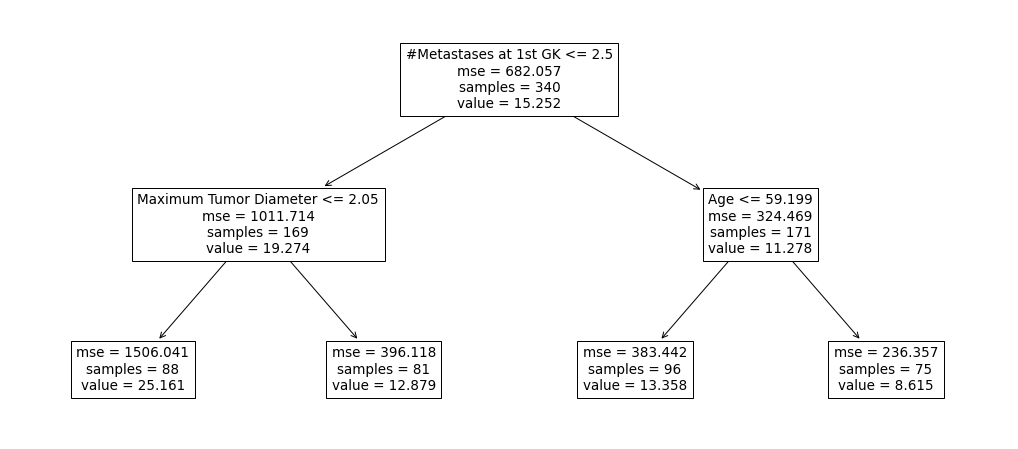

In [68]:
tree_plot_2(best_model_melanoma_w_tar_vol[1],modelling_data_w_tar_vol, 'Melanoma', h = 18)
plt.show()

In [241]:
best_model_melanoma_w_tar_vol

[DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=2,
                       min_samples_leaf=63),
 DecisionTreeRegressor(max_features='auto', max_leaf_nodes=4,
                       min_samples_leaf=74)]

### 3 Classes

#### Max Leaf nodes 3

In [252]:
rsquared, best_model = pick_best_model(modelling_data_w_tar_vol, 'Melanoma', iterations = 25, max_leaf_nodes = 3)

In [254]:
best_model_melanoma_w_tar_vol.append(best_model)

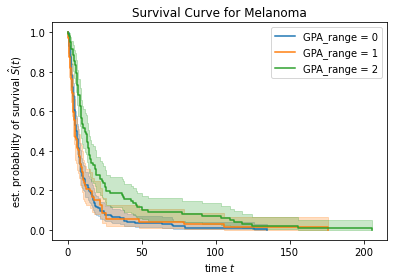

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,6.000000,4.918033,7.180328
0.5,Melanoma,1,4.655738,3.803279,7.606557
0.5,Melanoma,2,11.475410,8.885246,14.590164


In [69]:
survival_curve_and_ci(best_model_melanoma_w_tar_vol[2],
                      modelling_data_w_tar_vol, indication = 'Melanoma', tolerance = 0)

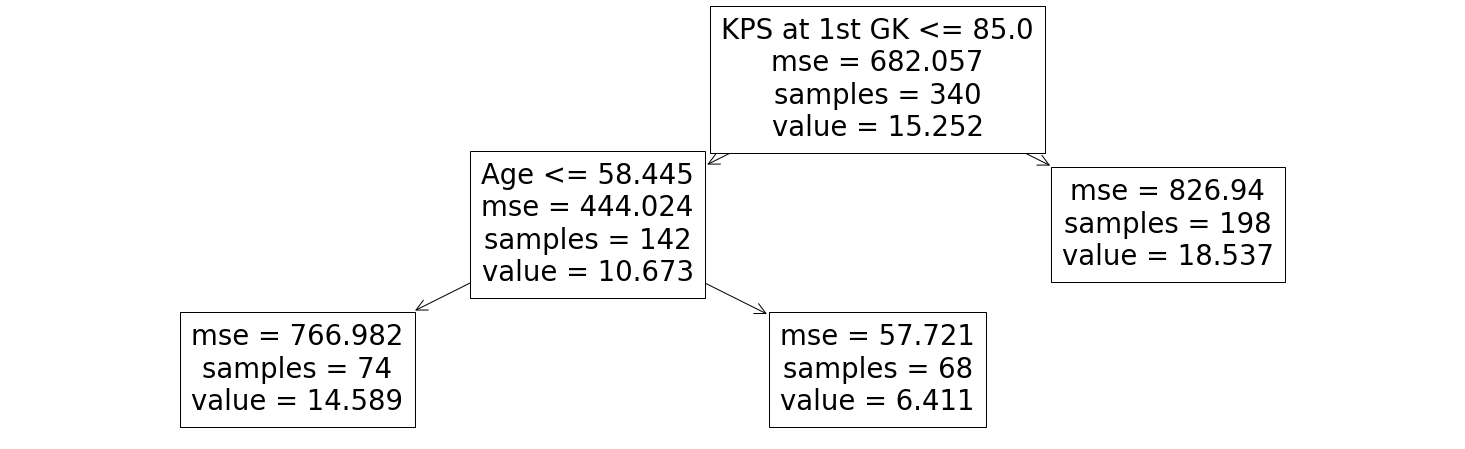

In [69]:
tree_plot_2(best_model_melanoma_w_max_dia[2],modelling_data_w_max_dia, 'Melanoma', h = 26)
plt.show()

#### Max Leaf nodes 5

In [278]:
rsquared, best_model = pick_best_model(modelling_data_w_tar_vol, 'Melanoma', iterations = 55, max_leaf_nodes = 5 )

In [280]:
best_model_melanoma_w_tar_vol.append(best_model)

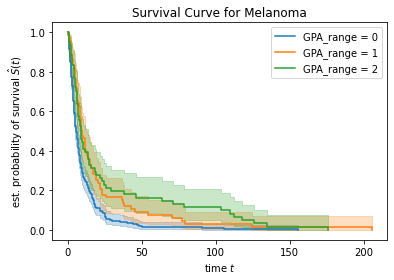

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,5.639344,4.655738,7.049180
0.5,Melanoma,1,9.377049,7.639344,13.311475
0.5,Melanoma,2,8.918033,6.885246,13.770492


In [71]:
survival_curve_and_ci(best_model_melanoma_w_tar_vol[3],
                      modelling_data_w_tar_vol, indication = 'Melanoma', tolerance = 2.5)

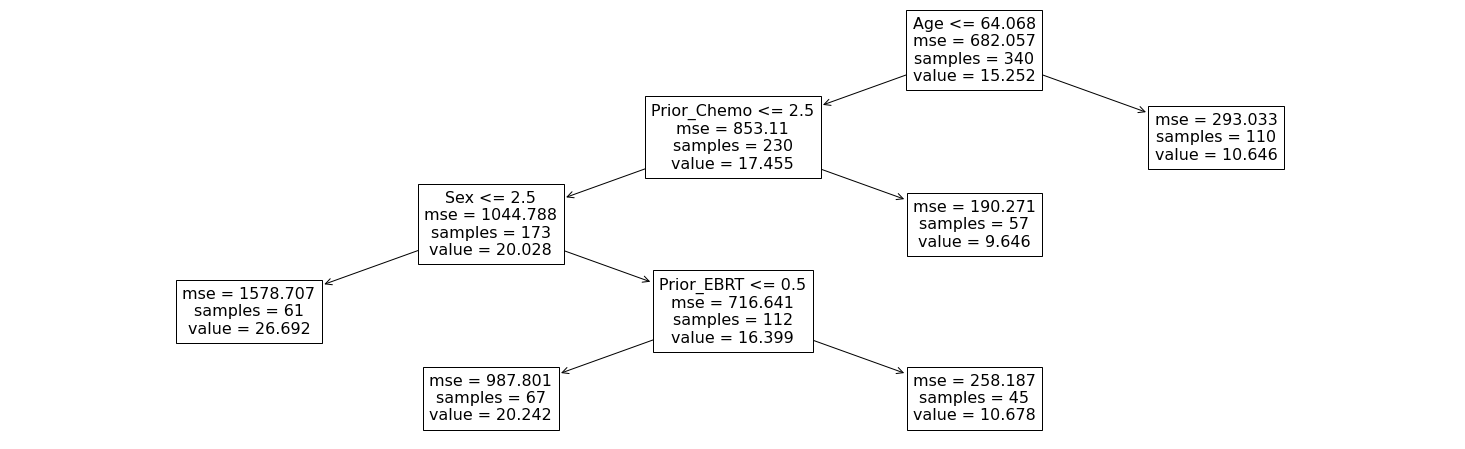

In [70]:
tree_plot_2(best_model_melanoma_w_tar_vol[3],modelling_data_w_tar_vol, 'Melanoma', h = 26)
plt.show()

#### Max Leaf nodes > 6

In [298]:
rsquared, best_model = pick_best_model(modelling_data_w_tar_vol, 'Melanoma', iterations = 25, max_leaf_nodes = 100 )

In [301]:
best_model_melanoma_w_tar_vol.append(best_model)

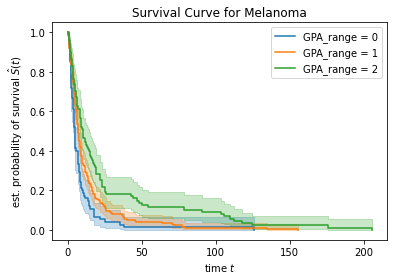

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,4.622951,3.540984,6.852459
0.5,Melanoma,1,7.245902,6.196721,8.360656
0.5,Melanoma,2,10.032787,8.163934,14.590164


In [73]:
survival_curve_and_ci(best_model_melanoma_w_tar_vol[4],modelling_data_w_tar_vol, 
                      indication = 'Melanoma', tolerance = 1)

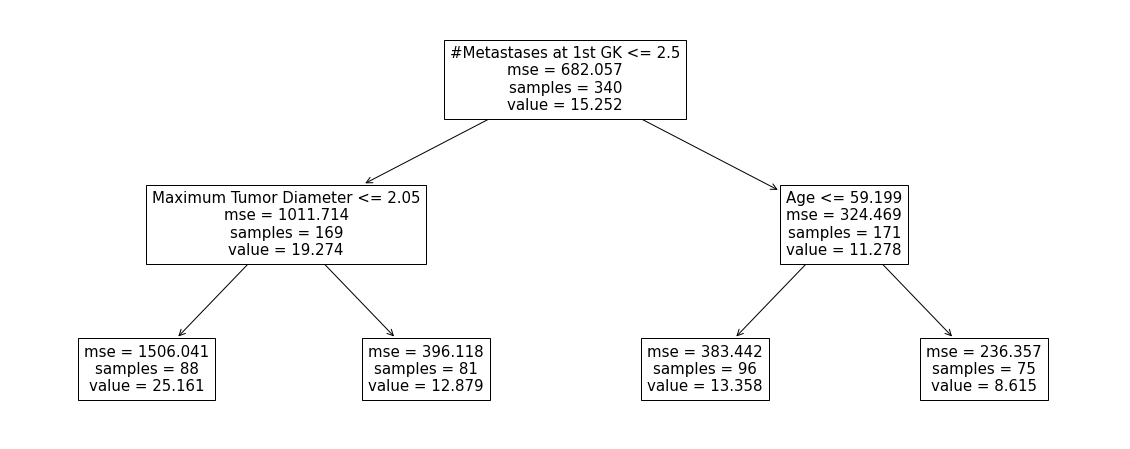

In [75]:
tree_plot_2(best_model_melanoma_w_tar_vol[4],modelling_data_w_tar_vol, 'Melanoma', h = 20)
plt.show()

### 4 Classes

In [319]:
rsquared, best_model = pick_best_model(modelling_data_w_tar_vol, 'Melanoma', iterations = 25, max_leaf_nodes = 4)


In [331]:
best_model_melanoma_w_tar_vol.append(best_model)

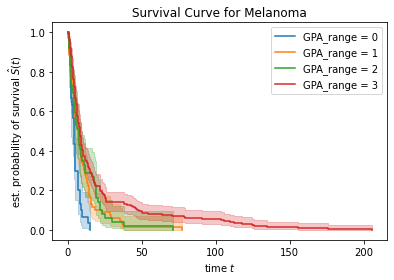

,Primary tumor Site,gpa_range,median,median_lower_lim,median_upper_lim
0.5,Melanoma,0,4.163934,2.491803,4.950820
0.5,Melanoma,1,6.754098,4.622951,8.524590
0.5,Melanoma,2,7.344262,4.360656,9.213115
0.5,Melanoma,3,8.327869,6.754098,9.278689


In [75]:
survival_curve_and_ci(best_model_melanoma_w_tar_vol[5],modelling_data_w_tar_vol, indication = 'Melanoma', tolerance = 0)

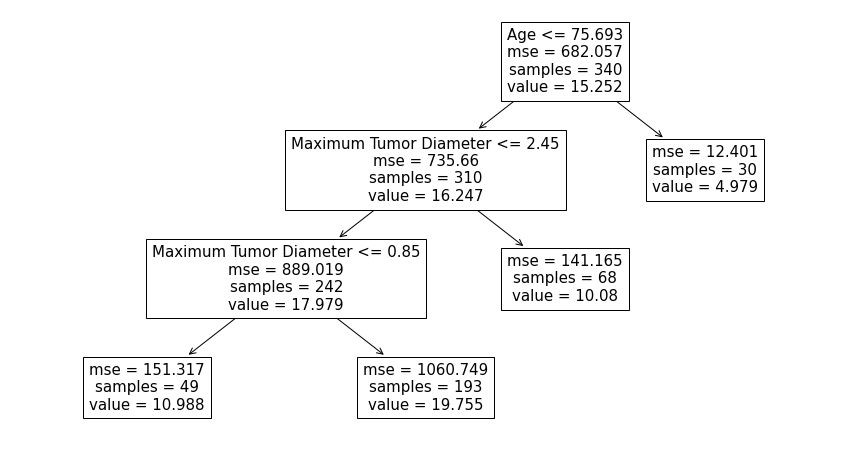

In [77]:
tree_plot_2(best_model_melanoma_w_tar_vol[5],modelling_data_w_tar_vol, 'Melanoma', h = 15)
plt.show()

In [336]:
joblib.dump(best_model_melanoma_w_tar_vol[0], 'melanoma_2_leaf_node_2_gpa_w_tar_vol')
joblib.dump(best_model_melanoma_w_tar_vol[1], 'melanoma_4_leaf_node_2_gpa_w_tar_vol')
joblib.dump(best_model_melanoma_w_tar_vol[2], 'melanoma_3_leaf_node_3_gpa_w_tar_vol')
joblib.dump(best_model_melanoma_w_tar_vol[3], 'melanoma_5_leaf_node_3_gpa_w_tar_vol')
joblib.dump(best_model_melanoma_w_tar_vol[4], 'melanoma_6_leaf_node_3_gpa_w_tar_vol')
joblib.dump(best_model_melanoma_w_tar_vol[5], 'melanoma_4_leaf_node_4_gpa_w_tar_vol')

['melanoma_4_leaf_node_4_gpa_w_tar_vol']

In [337]:
best_model_melanoma_w_tar_vol

[DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=2,
                       min_samples_leaf=63),
 DecisionTreeRegressor(max_features='auto', max_leaf_nodes=4,
                       min_samples_leaf=74),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=3,
                       min_samples_leaf=33),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=5,
                       min_samples_leaf=33),
 DecisionTreeRegressor(max_features='auto', max_leaf_nodes=100,
                       min_samples_leaf=73),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=4,
                       min_samples_leaf=23)]